# Seq2Seq - Encoder/Decoder networks
In this exercise we'll have a deeper look into the ability to use multiple RNN's to infer and generate sequences of data.
Specifically we will implement a Encoder-Decoder RNN based for a simple sequence to sequence translation task.
This type of models have shown impressive performance in Neural Machine Translation and Image Caption generation. 

In the encoder-decoder structure one RNN (blue) encodes the input into a hidden representation, and a second RNN (red) uses this representation to predict the target values.
An essential step is deciding how the encoder and decoder should communicate.
In the simplest approach you use the last hidden state of the encoder to initialize the decoder.
This is what we will do in this notebook, as shown here:

![](./images/enc-dec.png)

In this exercise we will translate from the words of number (e.g. 'nine') to the actual number (e.g. '9').
The input for the Encoder RNN consists of words defining the number, whilst the output of such an encoding serves as input for the Decoder RNN that aims to generate generate a number. 
Our dataset is generated and consists of numbers and an End-of-Sentence (EOS) character ('#'). The data we want to generate should be like follows:

```
Examples: 
prediction  |  input
991136#00 	 nine nine one one three six
81771#000 	 eight one seven seven one
3519614#0 	 three five one nine six one four
26656#000 	 two six six five six
60344#000 	 six zero three four four
162885#00 	 one six two eight eight five
78612625# 	 seven eight six one two six two five
9464710#0 	 nine four six four seven one zero
191306#00 	 one nine one three zero six
10160378# 	 one zero one zero six three seven eight
```

Let us define the space of characters and numbers to be learned with the networks:

```
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	' '=11,	'e'=12,	'g'=13,	'f'=14,	'i'=15,	'h'=16,	'o'=17,	'n'=18,	's'=19,	'r'=20,	'u'=21,	't'=22,	'w'=23,	'v'=24,	'x'=25,	'z'=26,	
Stop/start character = #
```

All represented characters and numbers as characters, gets mapped to an integer from 0-26. Our total space of valid characters consists of 27.

In [1]:
from data_generator import generate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_generator import generate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

NUM_INPUTS = 27 #No. of possible characters
NUM_OUTPUTS = 11  # (0-9 + '#')

### Hyperparameters and general configs
MAX_SEQ_LEN = 8
MIN_SEQ_LEN = 5
BATCH_SIZE = 16
TRAINING_SIZE = 16000
LEARNING_RATE = 0.001

# Hidden size of enc and dec need to be equal if last hidden of encoder becomes init hidden of decoder
# Otherwise we would need e.g. a linear layer to map to a space with the correct dimension
NUM_UNITS_ENC = NUM_UNITS_DEC = 96
TEST_SIZE = 200
EPOCHS = 15
TEACHER_FORCING = True

assert TRAINING_SIZE % BATCH_SIZE == 0

Device in use: cuda


For this exercise we won´t worry about data generation, but utilise a built function for this purpose. The function generates random data constained by the 27 characters described above.

The encoder takes as input the embedded text strings generated from the *generate* function as given here above ie. 'nine' would become [18 15 18 12].
Sequeneces are generated at random given settings of minima and maxima length, constrained by the dimensions of the two RNN´s architecture.
We may visualise a subset of the data generated by running the command below

In [2]:
!python ./data_generator.py

Generated batch length 3 from 3 iterations
input types: int32 int32 int32 int32 int32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	'x'=11,	'o'=12,	'e'=13,	't'=14,	'h'=15,	'f'=16,	'g'=17,	'w'=18,	'i'=19,	'n'=20,	'v'=21,	's'=22,	'u'=23,	' '=24,	'z'=25,	'r'=26,	
Stop/start character = #

SAMPLE 0
TEXT INPUTS:			 two zero
ENCODED INPUTS:			 [14 18 12 24 25 13 26 12  0  0  0  0  0  0  0  0]
INPUTS SEQUENCE LENGTH:	 8
TEXT TARGETS INPUT:		 #20
TEXT TARGETS OUTPUT:	 20#
ENCODED TARGETS INPUT:	 [10  2  0  0]
ENCODED TARGETS OUTPUT:	 [ 2  0 10  0]
TARGETS SEQUENCE LENGTH: 3
TARGETS MASK:			 [1. 1. 1. 0.]

SAMPLE 1
TEXT INPUTS:			 four six zero
ENCODED INPUTS:			 [16 12 23 26 24 22 19 11 24 25 13 26 12  0  0  0]
INPUTS SEQUENCE LENGTH:	 13
TEXT TARGETS INPUT:		 #460
TEXT TARGETS OUTPUT:	 460#
ENCODED TARGETS INPUT:	 [10  4  6  0]
ENCODED TARGETS OUTPUT:	 [ 4  6  0 10]
TARGETS SEQUENCE LENGTH: 4
TARGETS MASK:			 [1. 1. 1. 1.]

SAMPLE

In [3]:
# 2. These networks implement the GRU-gates. Implement an alternative control utilising a memory mechanism (Hint: LSTM). 
# What do you experience? 


## Let's define the two RNN's



In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, self.hidden_size)
        rnn = nn.LSTM
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)

    def forward(self, inputs, hidden):
        # Input shape [batch, seq_in_len]z
        inputs = inputs.long()

        # Embedded shape [batch, seq_in_len, embed]
        embedded = self.embedding(inputs)
        
        # Output shape [batch, seq_in_len, embed]
        # Hidden shape [1, batch, embed], last hidden state of the GRU cell
        # We will feed this last hidden state into the decoder
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        init = torch.zeros(1, batch_size, self.hidden_size, device=device)
        return init, init


In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        rnn = nn.LSTM
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)

    def forward(self, inputs, hidden, output_len, teacher_forcing=False):
        # Input shape: [batch, output_len]
        # Hidden shape: [seq_len=1, batch_size, hidden_dim] (the last hidden state of the encoder)

        if teacher_forcing:
            dec_input = inputs
            embed = self.embedding(dec_input)   # shape [batch, output_len, hidden_dim]
            out, hidden = self.rnn(embed, hidden)
            out = self.out(out)  # linear layer, out has now shape [batch, output_len, output_size]
            output = F.log_softmax(out, -1)
        else:
            # Take the EOS character only, for the whole batch, and unsqueeze so shape is [batch, 1]
            # This is the first input, then we will use as input the GRU output at the previous time step
            dec_input = inputs[:, 0].unsqueeze(1)

            output = []
            for i in range(output_len):
                out, hidden = self.rnn(self.embedding(dec_input), hidden)
                out = self.out(out)  # linear layer, out has now shape [batch, 1, output_size]
                out = F.log_softmax(out, -1)
                output.append(out.squeeze(1))
                out_symbol = torch.argmax(out, dim=2)   # shape [batch, 1]
                dec_input = out_symbol   # feed the decoded symbol back into the recurrent unit at next step

            output = torch.stack(output).permute(1, 0, 2)  # [batch_size x seq_len x output_size]

        return output

The learned representation from the *Encoder* gets propagated to the *Decoder* as the final hidden layer in the *Encoder* network is set as initialisation for the *Decoder*'s first hidden layer.

In [6]:
def forward_pass(encoder, decoder, x, t, t_in, criterion, max_t_len, teacher_forcing):
    """
    Executes a forward pass through the whole model.

    :param encoder:
    :param decoder:
    :param x: input to the encoder, shape [batch, seq_in_len]
    :param t: target output predictions for decoder, shape [batch, seq_t_len]
    :param criterion: loss function
    :param max_t_len: maximum target length

    :return: output (after log-softmax), loss, accuracy (per-symbol)
    """
    # Run encoder and get last hidden state (and output)
    batch_size = x.size(0)
    enc_h = encoder.init_hidden(batch_size)
    enc_out, enc_h = encoder(x, enc_h)

    dec_h = enc_h  # Init hidden state of decoder as hidden state of encoder
    dec_input = t_in
    out = decoder(dec_input, dec_h, max_t_len, teacher_forcing)
    out = out.permute(0, 2, 1)
    # Shape: [batch_size x num_classes x out_sequence_len], with second dim containing log probabilities

    loss = criterion(out, t)
    pred = get_pred(log_probs=out)
    accuracy = (pred == t).type(torch.FloatTensor).mean()
    return out, loss, accuracy


In [7]:
#print(batch_size)
#x.size(0)

In [8]:
def train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_t_len):
    encoder.train()
    decoder.train()
    
    for batch_idx, (x, t, t_in) in enumerate(zip(inputs, targets, targets_in)):
#############################################################################################################################  
        x = x.long().to(torch.device("cuda"))
        t = t.long().to(torch.device("cuda"))
        t_in = t_in.long().to(torch.device("cuda"))
        
        out, loss, accuracy = forward_pass(encoder, decoder, x, t, t_in, criterion, max_t_len, teacher_forcing = False)
            
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()

        

#########################################################################################################################        
        if batch_idx % 200 == 0:
            print('Epoch {} [{}/{} ({:.0f}%)]\tTraining loss: {:.4f} \tTraining accuracy: {:.1f}%'.format(
                epoch, batch_idx * len(x), TRAINING_SIZE,
                100. * batch_idx * len(x) / TRAINING_SIZE, loss.item(),
                100. * accuracy.item()))


In [9]:
def test(encoder, decoder, inputs, targets, targets_in, criterion, max_t_len):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        targets = targets.long().to(device)
        targets_in = targets_in.long().to(device)
        out, loss, accuracy = forward_pass(encoder, decoder, inputs, targets, targets_in, criterion, max_t_len,
                                           teacher_forcing=TEACHER_FORCING)
    return out, loss, accuracy

In [10]:
def numbers_to_text(seq):
    return "".join([str(to_np(i)) if to_np(i) != 10 else '#' for i in seq])

def to_np(x):
    return x.cpu().numpy()

def get_pred(log_probs):
    """
    Get class prediction (digit prediction) from the net's output (the log_probs)
    :param log_probs: Tensor of shape [batch_size x n_classes x sequence_len]
    :return:
    """
    return torch.argmax(log_probs, dim=1)

In [11]:
encoder = EncoderRNN(NUM_INPUTS, NUM_UNITS_ENC).to(device)
decoder = DecoderRNN(NUM_UNITS_DEC, NUM_OUTPUTS).to(device)
enc_optimizer = optim.RMSprop(encoder.parameters(), lr=LEARNING_RATE)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()

# Get training set
inputs, _, targets_in, targets, targets_seqlen, _, _, _, text_targ = generate(TRAINING_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN)
max_target_len = max(targets_seqlen)
inputs = torch.tensor(inputs)
targets = torch.tensor(targets)
targets_in = torch.tensor(targets_in)
unique_text_targets = set(text_targ)

# Get validation set
val_inputs, _, val_targets_in, val_targets, val_targets_seqlen, _, val_text_in, _, val_text_targ = \
    generate(TEST_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN, invalid_set=unique_text_targets)
val_inputs = torch.tensor(val_inputs)
val_targets = torch.tensor(val_targets)
val_targets_in = torch.tensor(val_targets_in)
max_val_target_len = max(val_targets_seqlen)
test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)

# Split training set in batches
inputs = [inputs[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets = [targets[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets_in = [targets_in[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]



# Quick and dirty - just loop over training set without reshuffling
for epoch in range(1, EPOCHS + 1):
    train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_target_len)
    _, loss, accuracy = test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)
    print('\nTest set: Average loss: {:.4f} \tAccuracy: {:.3f}%\n'.format(loss, accuracy.item()*100.))

    # Show examples
    print("Examples: prediction | input")
    out, _, _ = test(encoder, decoder, val_inputs[:10], val_targets[:10], val_targets_in[:10], criterion, max_val_target_len)
    pred = get_pred(out)
    pred_text = [numbers_to_text(sample) for sample in pred]
    for i in range(10):
        print(pred_text[i], "\t", val_text_in[i])
    print()

Generated batch length 16000 from 16000 iterations
Generated batch length 200 from 201 iterations
Epoch 1 [0/16000 (0%)]	Training loss: 2.4236 	Training accuracy: 8.3%
Epoch 1 [3200/16000 (20%)]	Training loss: 1.8868 	Training accuracy: 33.3%
Epoch 1 [6400/16000 (40%)]	Training loss: 1.8046 	Training accuracy: 31.9%
Epoch 1 [9600/16000 (60%)]	Training loss: 1.6578 	Training accuracy: 37.5%
Epoch 1 [12800/16000 (80%)]	Training loss: 1.5205 	Training accuracy: 41.7%

Test set: Average loss: 1.8813 	Accuracy: 32.111%

Examples: prediction | input
88883#000 	 five four five five nine
666363#00 	 six three zero seven five zero
2222222## 	 two nine six zero six one one
333333##0 	 two one zero five three eight
33333#000 	 four three five eight two
4200022## 	 zero three zero zero zero eight six
33333#000 	 four six seven five eight
788338##0 	 five six four eight eight five
2222222## 	 four zero six one one nine nine
7777737## 	 seven one nine eight three seven one seven

Epoch 2 [0/16000 (0

Epoch 10 [6400/16000 (40%)]	Training loss: 0.5172 	Training accuracy: 82.6%
Epoch 10 [9600/16000 (60%)]	Training loss: 0.3655 	Training accuracy: 84.7%
Epoch 10 [12800/16000 (80%)]	Training loss: 0.3914 	Training accuracy: 86.8%

Test set: Average loss: 0.6053 	Accuracy: 77.500%

Examples: prediction | input
44559#000 	 five four five five nine
630350#00 	 six three zero seven five zero
9960011#0 	 two nine six zero six one one
910538#00 	 two one zero five three eight
43582#000 	 four three five eight two
0300086#0 	 zero three zero zero zero eight six
56758#000 	 four six seven five eight
664885#00 	 five six four eight eight five
9061199#0 	 four zero six one one nine nine
77987717# 	 seven one nine eight three seven one seven

Epoch 11 [0/16000 (0%)]	Training loss: 0.4525 	Training accuracy: 81.2%
Epoch 11 [3200/16000 (20%)]	Training loss: 0.4979 	Training accuracy: 76.4%
Epoch 11 [6400/16000 (40%)]	Training loss: 0.4378 	Training accuracy: 84.7%
Epoch 11 [9600/16000 (60%)]	Trainin


Test set: Average loss: 0.3807 	Accuracy: 89.278%

Examples: prediction | input
54559#000 	 five four five five nine
630750#00 	 six three zero seven five zero
2960161#0 	 two nine six zero six one one
210538##0 	 two one zero five three eight
43582#000 	 four three five eight two
0303386#0 	 zero three zero zero zero eight six
46758#000 	 four six seven five eight
564885#00 	 five six four eight eight five
4061199## 	 four zero six one one nine nine
519831166 	 seven one nine eight three seven one seven

Epoch 20 [0/16000 (0%)]	Training loss: 0.1835 	Training accuracy: 92.4%
Epoch 20 [3200/16000 (20%)]	Training loss: 0.1780 	Training accuracy: 93.8%
Epoch 20 [6400/16000 (40%)]	Training loss: 0.1340 	Training accuracy: 95.1%
Epoch 20 [9600/16000 (60%)]	Training loss: 0.0830 	Training accuracy: 95.1%
Epoch 20 [12800/16000 (80%)]	Training loss: 0.0861 	Training accuracy: 96.5%

Test set: Average loss: 0.2783 	Accuracy: 91.111%

Examples: prediction | input
54559#000 	 five four five fiv

In [12]:
type(inputs)
#print(inputs)

list

# Exercise:

1. Implement missing code for the network in the *train* function. Your validation accuracy is expected to be <20% at this point.<br>
<b>Test set: Average loss: 0.8942 	Accuracy: 65.111%</b>
<br>

2. These networks implement the GRU-gates. Implement an alternative control utilising a memory mechanism (Hint: LSTM). What do you experience? <br>
<b>Test set: Average loss: 0.7065 	Accuracy: 73.500%</b><br>
Better accuracy is observed.<br>
<br>

3. There are some parameters in the model that may be optimized further, what could they be? Achieve >90% validation accuracy.<br>
<b>Changing lr from 0.003 to 0.03    ----->    Test set: Average loss: 2.0558 	Accuracy: 22.167%</b> <br>
<b>Changing lr from 0.003 to 0.0003    ----->    Test set: Average loss: 1.3059 	Accuracy: 52.944%</b> <br>
<b>Changing lr from 0.003 to 0.0001    ----->    Test set: Average loss: 0.5793 	Accuracy: 79.778%</b> <br>
Carrying on with lr = 0.001. <br>
<b>Changing batch_size = 4 ----->    Test set: Test set: Average loss: 0.6770 	Accuracy: 75.333%</b> <br>
<b>Changing batch_size = 16 ----->    Test set: Average loss: 0.8027 	Accuracy: 71.444%</b> <br>
<b>Changing batch_size = 2 ----->   Test set: Average loss: 0.7948 	Accuracy: 76.722% (TOOK FOR EVER) </b> <br>
<b>Setting batch_size = 16, training_size = 16000, epochs = 20, teacher_forcing = True ----->  Test set: Average loss: 0.4149 	Accuracy: 86.222%  </b> <br>
<b>Trying with lr = 0.005 -----> Test set: Average loss: 0.2783 	Accuracy: 91.111%</b> <br>




EXERCISE:
Try creating a network with just two layers - an input and an output layer, no hidden layer - with 784 and 10 neurons, respectively. Train the network using stochastic gradient descent. What classification accuracy can you achieve?


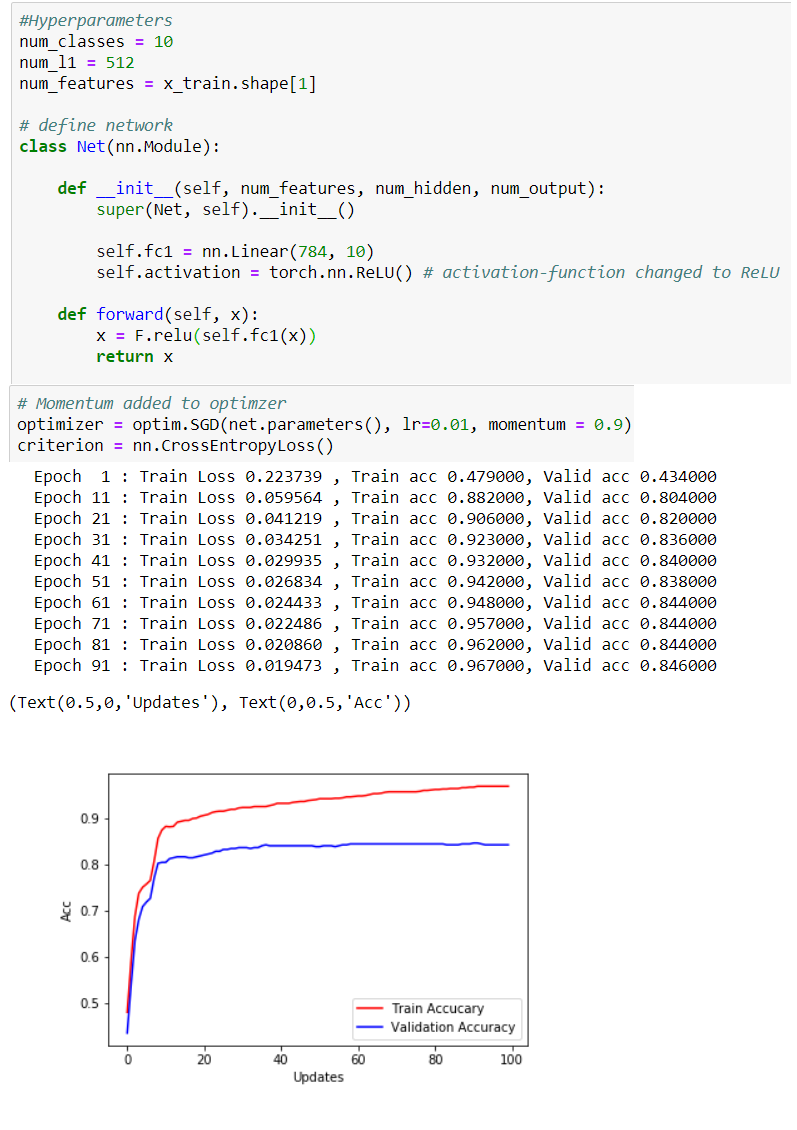